In [ ]:
%load_ext autoreload
%autoreload 2

In [3]:
import ast
import random
import pandas as pd
from tqdm import tqdm
from pathlib import Path
from pprint import pprint
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [4]:
def plot_tags_count(data: pd.DataFrame | dict, zoom_max=10000):
    if isinstance(data, pd.DataFrame):
        data = Counter([item for sublist in data['labels'] for item in sublist])
    sorted_values_cntr = {k: v for k, v in sorted(data.items(), key=lambda item: item[1], reverse=True)}

    if zoom_max:
        sorted_values_cntr = {k: v for k, v in sorted_values_cntr.items() if v < zoom_max}

    plt.figure(figsize=(10, 10))
    plt.pie(
        sorted_values_cntr.values(),
        labels=sorted_values_cntr.keys(),
        autopct='%1.1f%%', startangle=0
    )
    plt.axis('equal')
    plt.title('Label Distribution in Test Set')

    plt.show()


def plot_variance_per_key(data: dict):
    plt.figure(figsize=(10, 10))
    plt.bar(data.keys(), data.values())
    plt.title('Label Distribution in Test Set')
    plt.show()

In [5]:
SRC_DIR = Path('/Volumes/external_drive')

try:
    _df = pd.read_csv('datasets/images_high_res_dataset.csv')
except FileNotFoundError:
    _df = pd.read_csv(SRC_DIR / 'images_high_res_dataset.csv')

print("Dataset loaded.")
_df.drop(['models'], axis=1, inplace=True)
_df['categories'] = _df['categories'].apply(ast.literal_eval)
_df['categories_suggestions'] = _df['categories_suggestions'].apply(ast.literal_eval)
print("Parsed list columns categories")

Dataset loaded.
Parsed list columns categories


In [6]:
df = _df.copy(True)
df.shape

(1345430, 7)

# Merge suggestions and categories

In [7]:
def merge_categories(row):
    categories = set(row['categories'])
    categories_suggestions = set(row['categories_suggestions'])
    categories_superset = {category.strip().lower() for category in categories.union(categories_suggestions)}
    return list(categories_superset)


df['labels'] = df['categories'].apply(lambda x: [category.strip().lower() for category in x])
df['labels'] = df.apply(merge_categories, axis=1)
df.drop(['categories_suggestions', 'categories'], axis=1, inplace=True)
df.shape

(1345430, 6)

# Purge nationalities from tags

In [8]:
nationality_tags_to_purge = {
    'african',
    'american',
    'arab',
    'argentina',
    'australian',
    'brazilian',
    'british',
    'canadian',
    'chinese',
    'colombian',
    'cuban',
    'czech',
    'dutch',
    'european',
    'filipina',
    'french',
    'german',
    'hungarian',
    'indian',
    'italian',
    'japanese',
    'korean',
    'mexican',
    'pinay',
    'polish',
    'russian',
    'spanish',
    'thai',
    'ukrainian',
    'venezuela',
    'white'
}
nationality_tags_to_purge = {n.lower() for n in nationality_tags_to_purge}
df['labels'] = df.labels.apply(lambda x: list(set(x) - nationality_tags_to_purge))
df.shape

(1345430, 6)

# Apply gallery mapping

In [9]:
from galleries_mapping import *

def gallery_mapping(row):
    labels = row.labels

    out = []
    for L in labels:
        _fetched = GALLERIES_MAP.get(L, None)
        if _fetched is remove_tag:
            continue
        elif _fetched is remove_gallery:
            return None
        elif isinstance(_fetched, list):
            out.extend(_fetched)
        elif _fetched is keep_tag:
            out.append(L.lower())

    return list(set(out))


df['labels'] = df.apply(gallery_mapping, axis=1)
df = df[df['labels'].notnull()]
df.shape

(1107585, 6)

# Dataframe clean up

In [10]:
df['file_path'] = df['gallery_category'] + '/' + df['gallery_name'] + '/' + df['filename']
df = df.drop(
    ['gallery_category', 'gallery_name', 'filename'], axis=1
)
df.reset_index(inplace=True, drop=True)

In [11]:
df.drop(
    ['height', 'width'], axis=1, inplace=True
)

# Balancing the dataset

In [12]:
label_counts = Counter(item for sublist in df['labels'] for item in sublist)
ascending_labels = [
    k for k, v in sorted(label_counts.items(), key=lambda item: item[1])
]
label_proportions = {
    k: v / len(df) for k, v in sorted(label_counts.items(), key=lambda item: item[1])
}

In [13]:
def get_balanced_df(og_df, max_samples=1000):
    def get_rows_with_label(dataframe, label):
        return dataframe[dataframe['labels'].apply(lambda x: label in x)]

    balanced_dfs = {label: pd.DataFrame() for label in label_counts.keys()}

    for label in tqdm(ascending_labels, total=len(ascending_labels), desc='Balancing dataset'):
        label_df = get_rows_with_label(og_df, label)

        label_df = resample(
            label_df,
            n_samples=max_samples,
            random_state=42
        )

        balanced_dfs[label] = label_df

    balanced_df = pd.concat(balanced_dfs).drop_duplicates(subset='file_path').reset_index(drop=True)

    return balanced_df

In [14]:
small_balanced_df = get_balanced_df(df, max_samples=1000)
medium_balanced_df = get_balanced_df(df, max_samples=3000)
final_balanced_df = df.copy()

Balancing dataset: 100%|██████████| 111/111 [00:27<00:00,  4.01it/s]


In [15]:
small_balanced_df.to_csv('datasets/small_file_paths.csv')
medium_balanced_df.to_csv('datasets/medium_file_paths.csv')
final_balanced_df.to_csv('datasets/all_file_paths.csv')

# One hot encoding

In [16]:
def dataframe_one_hot_encoding(dataframe: pd.DataFrame):
    all_labels = set(label for labels in dataframe['labels'] for label in labels)
    one_hot_encoded = pd.DataFrame()

    for label in tqdm(all_labels, total=len(all_labels), desc='One hot encoding'):
        one_hot_encoded[label] = dataframe['labels'].apply(lambda x: 1 if label in x else 0)

    out_df = pd.concat([dataframe, one_hot_encoded], axis=1)
    out_df.reset_index(drop=True, inplace=True)

    cols_sorted = sorted(list(out_df.columns))
    cols_sorted.remove("file_path")
    cols_sorted.remove("labels")

    return out_df[["file_path", "labels", *cols_sorted]]

In [17]:
small_final_df = dataframe_one_hot_encoding(small_balanced_df)
medium_final_df = dataframe_one_hot_encoding(medium_balanced_df)
final_df = dataframe_one_hot_encoding(df)

One hot encoding:  90%|█████████ | 100/111 [00:06<00:00, 15.50it/s]/var/folders/cq/qnm4dkj53rq748w0d5l1yz5h0000gn/T/ipykernel_5788/4168988818.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  one_hot_encoded[label] = dataframe['labels'].apply(lambda x: 1 if label in x else 0)
/var/folders/cq/qnm4dkj53rq748w0d5l1yz5h0000gn/T/ipykernel_5788/4168988818.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  one_hot_encoded[label] = dataframe['labels'].apply(lambda x: 1 if label in x else 0)
One hot encoding:  92%|█████████▏| 102/111 

In [18]:
small_final_df.to_csv("datasets/small_one_hot.csv")
medium_final_df.to_csv("datasets/medium_one_hot.csv")
final_df.to_csv("datasets/all_one_hot.csv")

# AI GEN

In [20]:
from galleries_mapping import *

In [29]:
_mandatory_columns = [
    'age',
]
mandatory_columns = list(
    x.strip() for x in AI_GEN_TAGS[_mandatory_columns].values.flatten() if isinstance(x, str)
)
_negative_columns = [
    'negative', 'more_people'
]
negative_columns = list(
    x.strip() for x in AI_GEN_TAGS[_negative_columns].values.flatten() if isinstance(x, str)
)
tags_to_drop = {
    'blowjob', 'reality', 'hardcore', 'cumshot', 'cowgirl', 'ass fucking', 'doggy style', 'teen', 'lesbian', 'model',
    'big cock', 'anal', 'bdsm', 'bondage', 'fetish', 'face', 'kissing', 'handjob', 'facial', 'fingering', 'groupsex',
    'cum in mouth', 'old young', 'titjob', 'interracial', 'pussy licking', 'threesome', 'pov', 'femdom', 'christmas',
    'girlfriend', 'cosplay', 'facesitting', 'massage', 'deepthroat', 'strapon', 'cheating', 'humping', 'cum in pussy',
    'ass licking', 'creampie', 'ball licking', 'spanking', 'orgasm', 'double penetration', 'couple', 'family',
    'anal gape', 'bbc', 'party', 'schoolgirl', 'fisting', 'missionary', 'squirting', 'pissing', 'gangbang', 'old man',
    'ffm', 'cuckold', 'seduction', 'tribbing', 'orgy', 'flexible', 'cfnm', 'footjob', 'blowbang', 'pegging', 'pregnant',
    'swingers', 'gloryhole', 'caught', 'college', 'yoga', 'casting', 'stripper', 'step sister', 'voyeur', 'mmf',
    'bukkake', 'gyno', 'small cock', 'babysitter', 'cheerleader', 'cum swapping', 'bisexual', 'goth', 'braces', 'pawg',
    'pretty', 'pigtails', 'emo', 'latex', 'babe', 'step brother', 'twink', 'shemale', 'ballerina', 'twins', 'pornstar',
    'model', 'latex', 'emo', 'latex', 'babe', 'leather', 'pigtails', 'halloween', 'wedding',
    'tall', 'doctor', 'vintage', 'rough sex', 'sex', 'gym', 'sandals', 'big woman', 
}

In [30]:
def filter_positives(row):
    labels = row.labels

    for L in labels:
        if L in mandatory_columns:
            return labels


def filter_negatives(row):
    labels = row.labels
    for L in labels:
        if L in negative_columns:
            return None
        if L in tags_to_drop:
            return None
    return labels


ai_df = df.copy()
ai_df['labels'] = ai_df.apply(filter_positives, axis=1)
ai_df = ai_df[ai_df['labels'].notnull()]
print(ai_df.shape)

ai_df['labels'] = ai_df.apply(filter_negatives, axis=1)
ai_df = ai_df[ai_df['labels'].notnull()]
print(ai_df.shape)

(330205, 2)
(186613, 2)


In [31]:
ai_df.reset_index(inplace=True, drop=True)

In [32]:
ai_df['labels_length'] = ai_df['labels'].apply(len)
ai_df = ai_df[ai_df['labels_length'] > 5]
ai_df.drop(['labels_length'], axis=1, inplace=True)
ai_df.reset_index(drop=True, inplace=True)
ai_df.to_csv('datasets/ai_gen_dataset_5_cats.csv')
print("5 cats df shape:", ai_df.shape)

ai_df['labels_length'] = ai_df['labels'].apply(len)
ai_df = ai_df[ai_df['labels_length'] > 10]
ai_df.drop(['labels_length'], axis=1, inplace=True)
ai_df.reset_index(drop=True, inplace=True)
ai_df.to_csv('datasets/ai_gen_dataset_10_cats.csv')
print("10 cats df shape:", ai_df.shape)

5 cats df shape: (134303, 2)
10 cats df shape: (104239, 2)


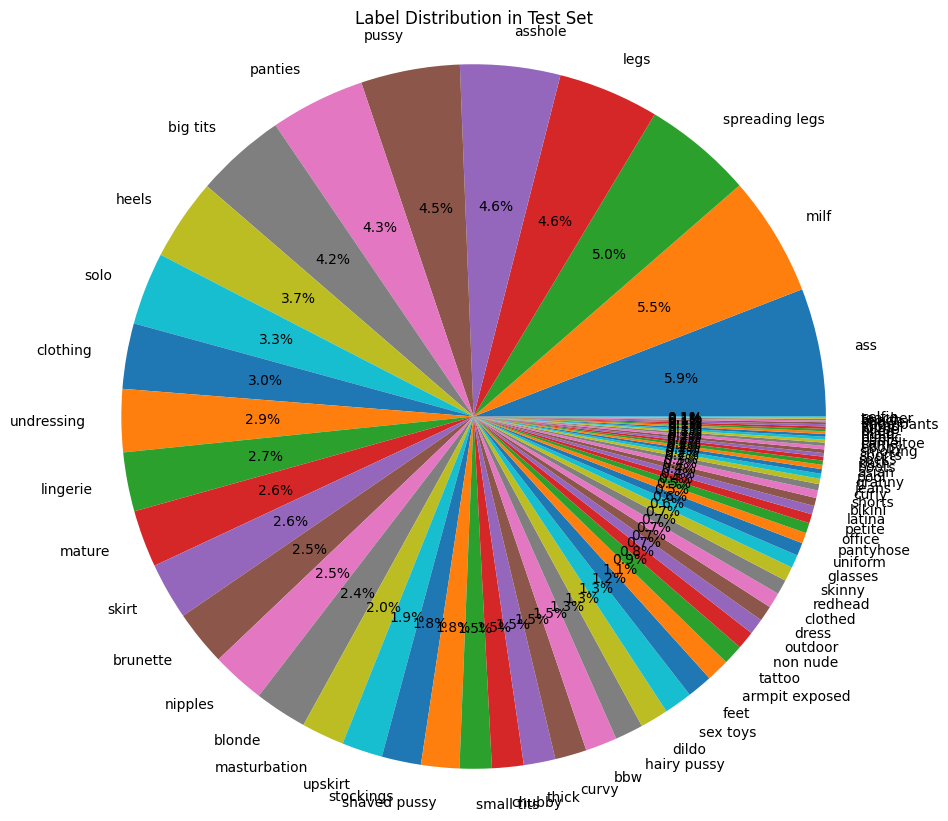

In [35]:
plot_tags_count(ai_df, zoom_max=100000)

In [36]:
cats_5 = pd.read_csv('datasets/ai_gen_dataset_5_cats.csv', index_col=0)
cats_10 = pd.read_csv('datasets/ai_gen_dataset_10_cats.csv', index_col=0)
small_one_hot = pd.read_csv('datasets/small_one_hot.csv', index_col=0)
medium_one_hot = pd.read_csv('datasets/medium_one_hot.csv', index_col=0)

In [37]:
for x in [cats_5, cats_10, small_one_hot, medium_one_hot]:
    missing = 0
    for file_path in x['file_path']:
        file_path = Path(file_path)
        json_path = SRC_DIR / file_path.parent / 'cropped' / (file_path.stem + '.json')
        if not json_path.exists():
            missing += 1
            
    print(f">>>>> Missing files: {missing} for out of {x.shape[0]}")

>>>>> Missing files: 73659 for out of 134303
>>>>> Missing files: 62857 for out of 104239
>>>>> Missing files: 41287 for out of 94148
>>>>> Missing files: 113102 for out of 241686
